In [27]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
import statsmodels.api as sm
from statsmodels.graphics import regressionplots as rplots
from statsmodels.graphics import gofplots 
from statsmodels.nonparametric.kernel_regression import KernelReg

#from sklearn_xarray import Stacker, Select

In [28]:
##function definition
from functions import *
from climada_functions import *
from constants import * 
import loess_jtrive
from Linear_Reg_Diagnostic import Linear_Reg_Diagnostic

In [29]:
def standardize(df):
    # anomalies
    andf = df - df.mean()
    # standardized
    std_df = andf/df.std()
    return std_df

## Select and load data

In [30]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=2E6
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season+scen
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)

#dic to map each impact func to its preprocessing function
pp_func_dic = {'Cubic excess-over-threshold':scale_qt,'Emanuel 2011':mask_qt,'Welker 2021':mask_qt}

# load indices

In [31]:
##Member mean

#normalized
dind_fn = "diff_remote_indices_sp_avg_modlist_allscen_historical_ssp585.csv"
dind_df = pd.read_csv(pathcirc+dind_fn,header=[0],index_col=[0,1])

dind_memmean_df = dind_df.copy()
# get member mean
dind_memmean_df = dind_memmean_df.groupby("model",axis=0).mean()

# add multimodel mean
#dind_memmean_df.loc["mean",:] =  dind_memmean_df.mean()

# anomalies
an_dind_memmean_df = dind_memmean_df - dind_memmean_df.mean()

#standardize
std_an_dind_memmean_df = an_dind_memmean_df/dind_memmean_df.std()

In [32]:
##Memsep 
dind_memsep_df = dind_df.copy()

# add multimodel mean
#dind_memsep_df.loc[("mean",""),:] =  dind_memsep_df.mean()

# anomalies
an_dind_memsep_df = dind_memsep_df - dind_memsep_df.mean()

#standardize
std_an_dind_memsep_df = an_dind_memsep_df/dind_memsep_df.std()

In [33]:
std_an_dind_memsep_df

sfcT       pol      trop     strat
model            imem                                        
CanESM5          0     1.800450  1.867830  1.796681  0.921386
                 1     1.742826  1.804418  1.787742  0.598489
                 2     1.670426  1.537200  1.736449 -0.360470
CNRM-CM6-1       0     0.404906  0.151950  0.815318  1.064869
                 1     0.462936 -0.012748  0.878675 -1.667423
                 2     0.646668  0.352945  0.937741 -1.685248
CNRM-ESM2-1      0    -0.032781 -0.302638  0.424604 -0.322182
                 1    -0.022694 -0.395910  0.455555 -1.803939
                 2     0.259760  0.319440  0.581756 -1.345902
EC-Earth3-Veg    0     0.075511 -0.124832  0.109085 -0.127299
                 1     0.415440  0.630196  0.208351 -1.541649
                 2     0.103693  0.047088  0.058579 -0.483567
EC-Earth3-Veg-LR 0    -0.060727  0.057493  0.045064 -1.007029
                 1     0.389334  0.630875  0.223476 -0.288773
                 2     0.473342  0.963840  0.267838 -1.267407
IPSL-CM6A-LR     0     0.694192  0.442109  1.012998  0.521420
                 1     0.725202  0.501234  1.006850  0.824961
                 2     0.421127  0.057137  0.784737  0.751034
MIROC-ES2L       0    -0.779079 -0.303895 -0.541285  1.527503
                 1    -0.890890 -0.411796 -0.672782  0.913465
                 2    -0.940468 -0.510548 -0.610525  1.161521
UKESM1-0-LL      0     1.741758  1.446797  1.171422 -0.959344
                 1     1.975320  1.692102  1.278303 -0.404893
                 2     1.689542  1.186976  1.166956 -0.856407
MRI-ESM2-0       0    -0.543725 -0.262138 -0.343093  1.477965
                 1    -0.571446 -0.412222 -0.302682  0.357570
                 2    -0.563584 -0.296883 -0.369344 -0.732123
FGOALS-g3        0    -1.455972 -0.812600 -1.102546 -0.613413
                 1    -1.521407 -0.964999 -1.128300 -0.498329
                 2    -1.944876 -1.363996 -1.492298 -0.882837
ACCESS-ESM1-5    0    -0.211816 -0.013195 -1.760595 -0.093380
                 1    -0.154286  0.015477 -1.706829 -0.112475
                 2    -0.180306  0.066557 -1.712257 -0.073819
MIROC6           0    -1.132124 -0.327534 -1.096171  0.269222
                 1    -1.107132 -0.531127 -1.048700 -0.156539
                 2    -1.033494 -0.222559 -0.996172  0.242937
MPI-ESM1-2-LR    0    -1.220882 -0.825121 -0.969651  0.764641
                 1    -1.171647 -0.730939 -0.866581  1.217712
                 2    -1.107674 -0.553378 -0.955503  0.683026
KACE-1-0-G       0     0.329036 -4.059340  0.301623  2.563654
                 1     0.377924 -0.037573  0.351201  0.754066
                 2     0.247619 -0.295691  0.274311  0.669005

In [34]:
##Memsep ratio fut / past
rind_fn = "ratio_remote_indices_sp_avg_modlist_allscen_historical_ssp585.csv"
rind_df = pd.read_csv(pathcirc+rind_fn,header=[0],index_col=[0,1])

rind_memsep_df = rind_df.copy()

# anomalies
an_rind_memsep_df = rind_memsep_df - rind_memsep_df.mean()

#standardize
std_an_rind_memsep_df = an_rind_memsep_df/rind_memsep_df.std()

## Multiple regression on regional AAI
1) Select simulation
2) Intiate df to save results
3) Loop over models, compute q98 fut-past diff, regrid and concat into the same array
5) regression on each gridcell of the q98 map



In [37]:
#select vars
modlist = modlist_allscen
sel_impf = 'CubEOT'
caltype = "AAI_EMDAT"
imp_metric = "aai_agg"

reglist = reglist2
pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmems = 3
qt = 0.98
regaaifn = make_fn(["reg",imp_metric,sel_impf,caltype,futname,pastname],basename=basenamemet_proc,filetype=".csv")


In [38]:
#intiate df to save result
#initiate df to store results
iterrows = [modlist,range(nmems)]
row_idx= pd.MultiIndex.from_product(iterrows,names=["model","imem"])
itercols = [reglist,[pastname,futname]]

col_idx= pd.MultiIndex.from_product(itercols,names=["region","period"])

reg_aai_df = pd.DataFrame(index=row_idx,columns=col_idx)



# Multiple Linear Regression

In [43]:
#select vars
modlist = modlist_allscen
reglist = reglist2

ind_df = std_an_dind_memmean_df
sel_impf = 'CubEOT'
caltype = "AAI_EMDAT"
imp_metric = "aai_agg"

pastname = 'historical'
futname = 'ssp585'
timeres='day'
nmems = 3
qt = 0.98
regaaifn = make_fn(["reg",imp_metric,sel_impf,caltype,futname,pastname],basename=basenamemet_proc,filetype=".csv")


In [44]:
#specify model
norm = True #normalized by global warming
logresp = True
preds = ["pol","trop","strat"] #predictors


In [52]:
#load y data
reg_aai_df = pd.read_csv(pathcirc+regaaifn,header=[0,1],index_col=[0,1])
#memmean
reg_aai_df = reg_aai_df.groupby("model",axis=0).mean()
if logresp:
    reg_aai_df = np.log(reg_aai_df)


In [60]:
##remove outliers
#no log trans
outliers1 = [('KACE-1-0-G',0),('CNRM-ESM2-1',1)]
outliers2 = outliers1 + [('EC-Earth3-Veg-LR',0),('CNRM-ESM2-1',0)]
outliers3 = outliers2 + [('EC-Earth3-Veg',0)]
outliers4 = outliers3 + [('EC-Earth3-Veg',2)]
outliers5 = outliers4 + [('KACE-1-0-G',2)]

#log trans
outliers1lt = [('KACE-1-0-G',0),('CNRM-ESM2-1',1)]
outliers2lt = outliers1lt + [('EC-Earth3-Veg-LR',0),('CNRM-ESM2-1',0)]
outliers3lt = outliers2lt + [('EC-Earth3-Veg',0)]
outliers4lt = outliers3lt + [('EC-Earth3-Veg',2)]
outliers5lt = outliers4lt + [('KACE-1-0-G',2)]

#memmean
outliers1mm = ['CNRM-ESM2-1']
outliers2mm = outliers1mm + ['EC-Earth3-Veg']
#outliers3lt = outliers2lt + [('EC-Earth3-Veg',0)]
#outliers4lt = outliers3lt + [('EC-Earth3-Veg',2)]
#outliers5lt = outliers4lt + [('KACE-1-0-G',2)]


outliers = outliers1mm
ind_df = ind_df.drop(index=outliers)
reg_aai_df = reg_aai_df.drop(index=outliers)

In [61]:
ind_df

,sfcT,pol,trop,strat
model,,,,
ACCESS-ESM1-5,-0.178976,0.026533,-1.688596,-0.112359
CNRM-CM6-1,0.496079,0.189689,0.857955,-0.919125
CanESM5,1.707754,2.007882,1.734625,0.465791
EC-Earth3-Veg,0.194776,0.212932,0.122582,-0.864773
EC-Earth3-Veg-LR,0.262679,0.636812,0.174861,-1.029770
FGOALS-g3,-1.612290,-1.210868,-1.213759,-0.801322
IPSL-CM6A-LR,0.602865,0.385616,0.914306,0.842637
KACE-1-0-G,0.312673,-1.693046,0.302250,1.601667
MIROC-ES2L,-0.855052,-0.472630,-0.594824,1.447300


In [62]:
# construct df to save results
row_idx = ["intercept"]+preds+["Rsq","adj-Rsq"]
mlr_df = pd.DataFrame(index=row_idx,columns=reglist)

In [63]:
#mlr for each region using statsmodel
mlr_df2 = pd.DataFrame(index=row_idx,columns=reglist)
X = ind_df.loc[:,preds]
Ts = ind_df.loc[:,["sfcT"]]

if norm:
    X = X/Ts.values
X = sm.add_constant(X) # adding a constant

fit_dict = {}
sum_tables = {}
for reg in reglist:
    #select data
    aai_reg = reg_aai_df.loc[:,reg]
    y = aai_reg.loc[:,futname] - aai_reg.loc[:,pastname]
    if norm:
        y = y.divide(Ts.values.flatten())
    lm = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight()) # describe model
    fit = lm.fit() # fit model
    fit_dict[reg] = fit
    sum_tables[reg] = fit.summary()

    

# Model diagnosis

In [64]:
## summary tables
sum_tables

{'BI': <class 'statsmodels.iolib.summary.Summary'>
 """
                     Robust linear Model Regression Results                    
 Dep. Variable:                      y   No. Observations:                   13
 Model:                            RLM   Df Residuals:                        9
 Method:                          IRLS   Df Model:                            3
 Norm:                   TukeyBiweight                                         
 Scale Est.:                       mad                                         
 Cov Type:                          H1                                         
 Date:                Wed, 15 Jun 2022                                         
 Time:                        15:51:03                                         
 No. Iterations:                    15                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ---------------------------------------------------------------

In [65]:
## construct table
row_idx = ["const"]+preds+["Rsq","adj-Rsq"]
sum_df = pd.DataFrame(index=row_idx,columns=reglist)
pval_df = pd.DataFrame(index=["const"]+preds,columns=reglist)

for reg in reglist:
    fitreg = fit_dict[reg]
    #Rsquared
    #sum_df.loc["Rsq",reg] = fitreg.rsquared
    #sum_df.loc["adj-Rsq",reg] = fitreg.rsquared_adj
    
    #coefs and pvals
    coefs = fitreg.params
    pvals = fitreg.pvalues
    for varname, coef in coefs.items():
        sum_df.loc[varname,reg] = coef
        pval_df.loc[varname,reg] = pvals[varname]
        

In [71]:
fitreg.bse

const    0.309424
pol      0.234289
trop     0.109142
strat    0.180153
dtype: float64

In [66]:
def style_005low(v, props=''):
    return props if v < 0.05 else None
pval_df.index.name = 'p-values'
spval = pval_df.style.applymap(style_005low, props='color:red;')
spval.format('{:.4f}')

,BI,IP,FR,ME,MD,SC,EA
p-values,,,,,,,
const,0.0707,0.2227,0.4793,0.6363,0.3881,0.0002,0.7834
pol,0.0001,0.7256,0.0468,0.2544,0.4709,0.0001,0.0410
trop,0.1056,0.3580,0.3814,0.6004,0.0000,0.0000,0.0942
strat,0.0246,0.5766,0.8164,0.0596,0.2455,0.0002,0.5544


In [67]:
sum_df.index.name = 'coefs'

sum_df.style.format('{:.2}')


,BI,IP,FR,ME,MD,SC,EA
coefs,,,,,,,
const,-1.0,-0.54,-0.47,-0.2,-0.17,0.85,-0.085
pol,1.7,0.12,0.99,0.37,-0.11,-0.65,0.48
trop,-0.33,0.14,-0.2,-0.08,0.5,-0.6,-0.18
strat,0.75,-0.14,0.089,-0.47,-0.14,-0.49,0.11
Rsq,nan,nan,nan,nan,nan,nan,nan
adj-Rsq,nan,nan,nan,nan,nan,nan,nan


## Diagnosis plots


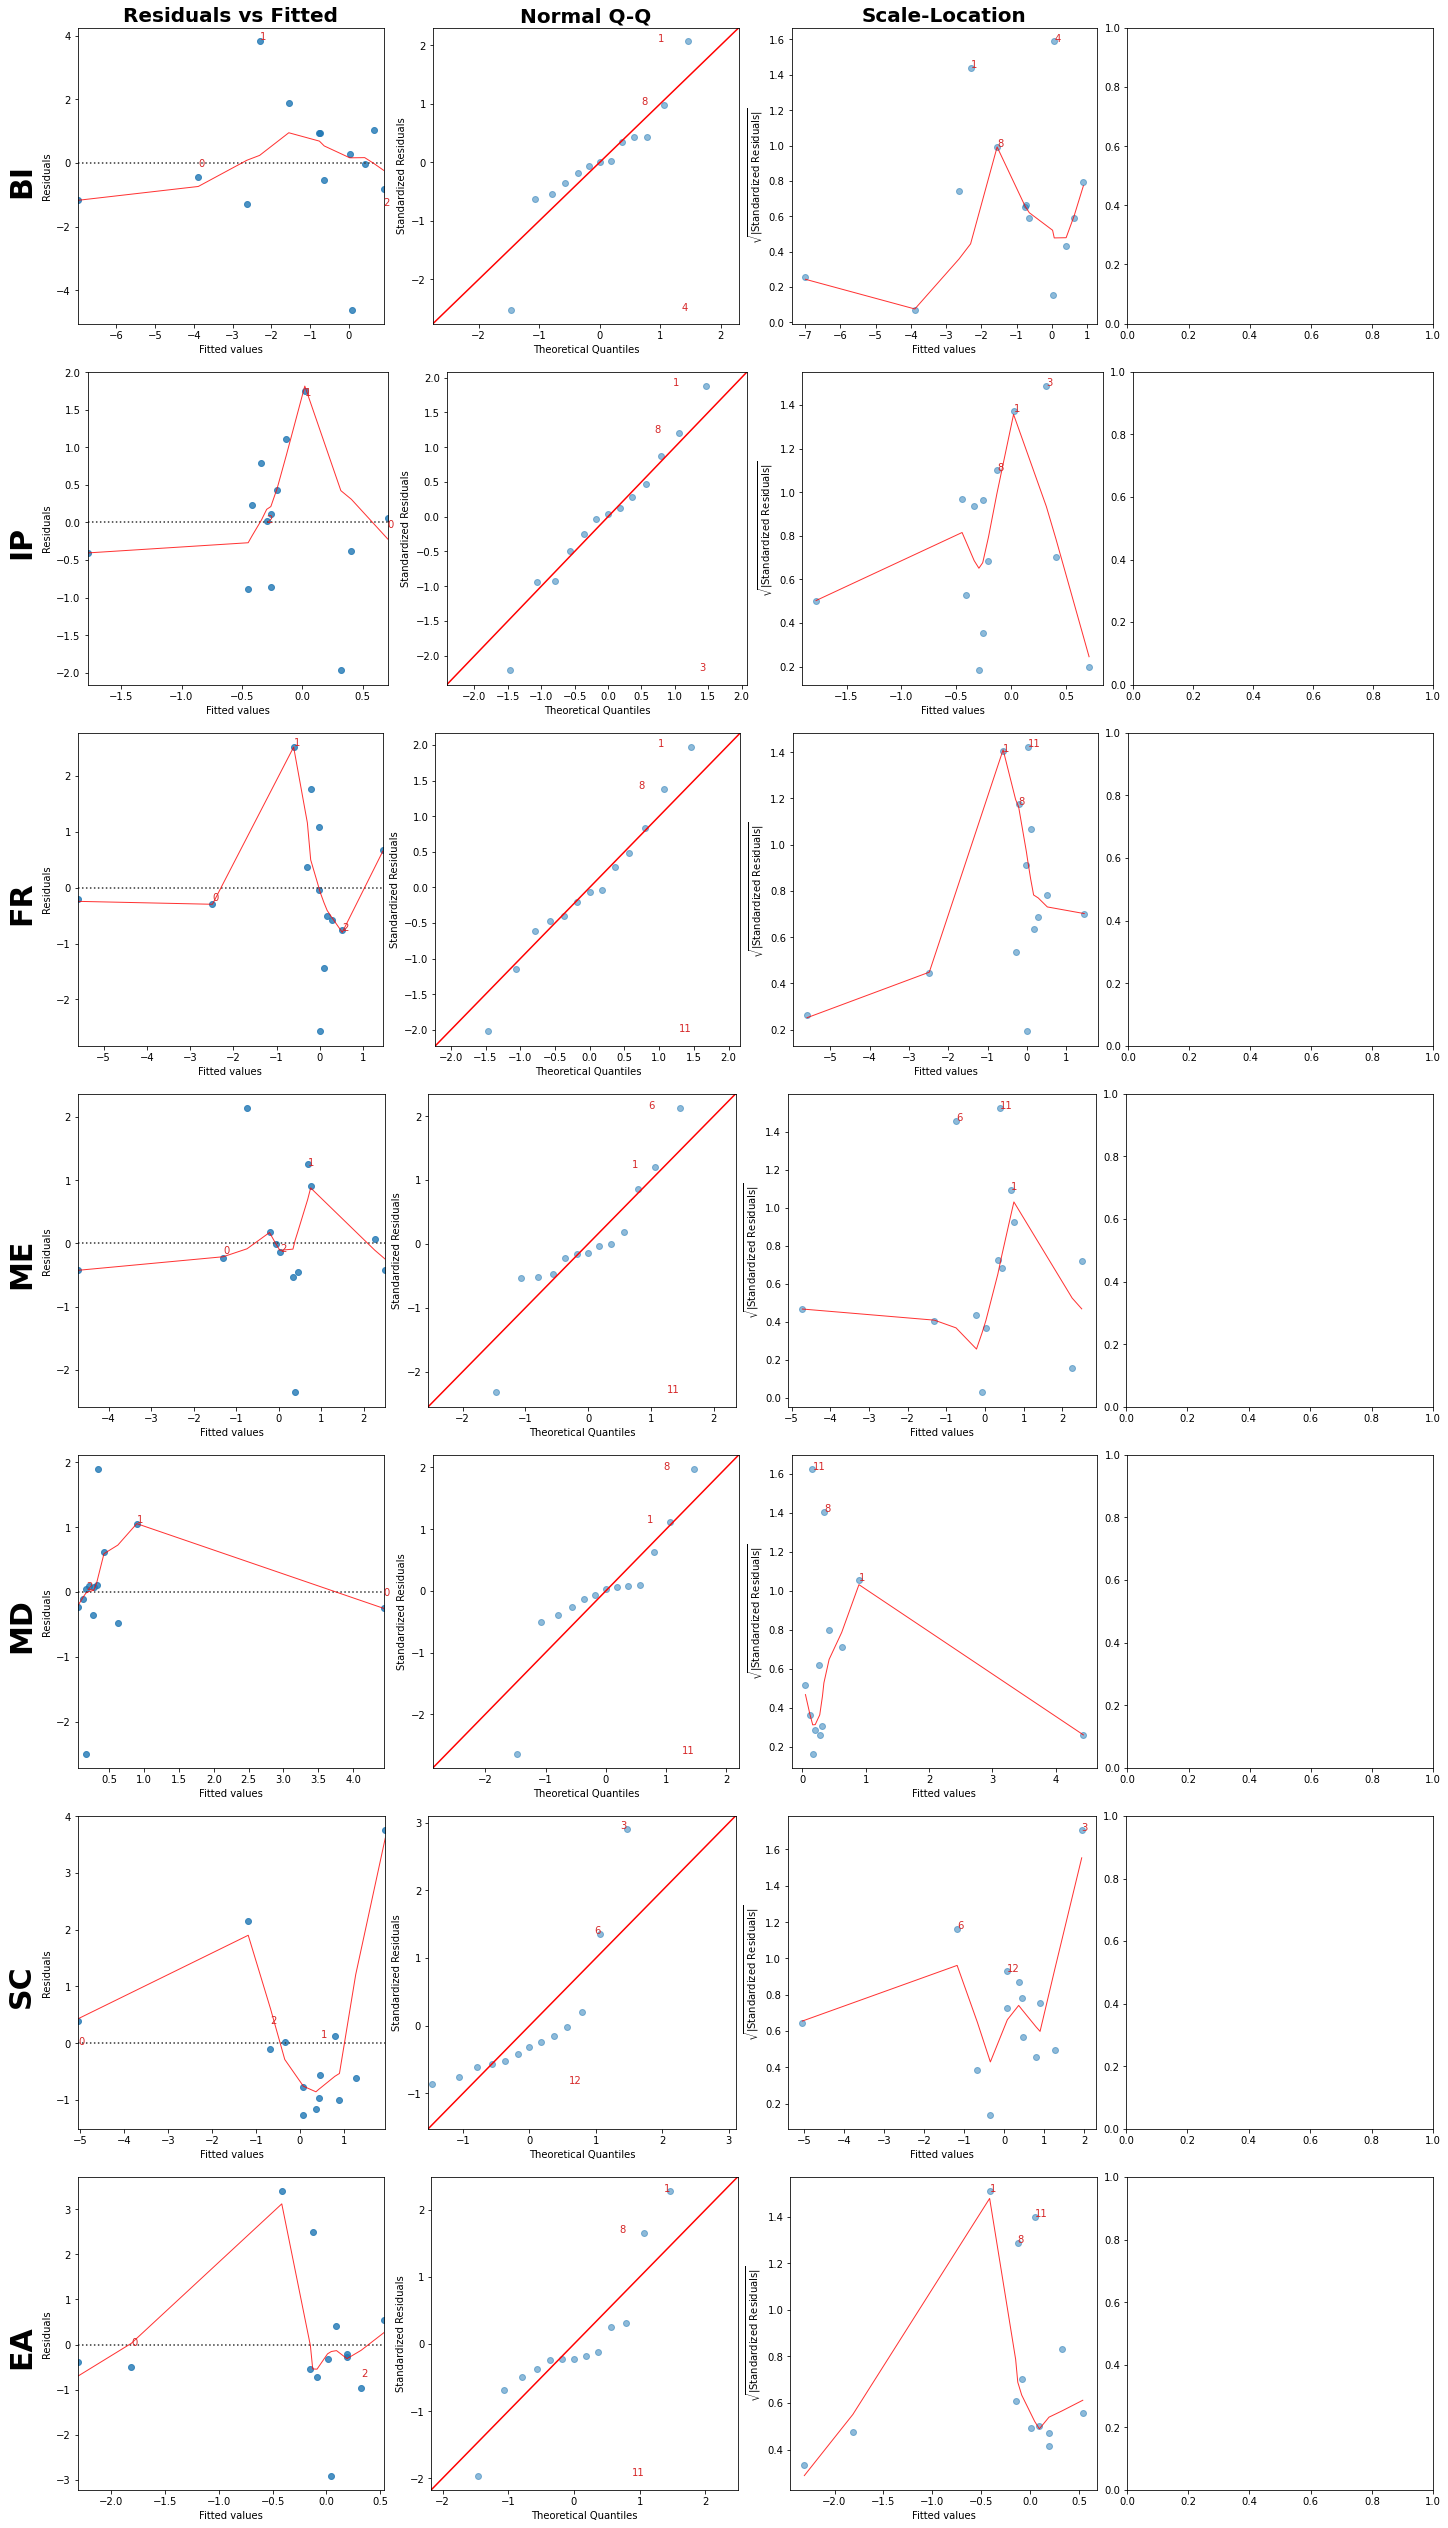

In [68]:
nregs = len(reglist)
nplots = 4
fig = plt.figure(constrained_layout=True,figsize=(5*nplots,5*nregs))
subfigs = fig.subfigures(nrows=nregs, ncols=1)
#axs = fig.subplots(nregs,sharex=False,sharey=False)
for ireg, reg in enumerate(reglist):
    #get linear reg
    fitreg = fit_dict[reg]
    diag = Linear_Reg_Diagnostic(fitreg,influence=False)
    subfig = subfigs[ireg]
    #get axes
    axs = subfig.subplots(nrows=1, ncols=nplots)
    
    #residual plot
    diag.residual_plot(ax=axs[0],scatter_kws=None)
    
    #qq plot
    diag.qq_plot(ax=axs[1])
    
    #scale loca
    diag.scale_location_plot(ax=axs[2])
    
    #leverage plot
    #diag.leverage_plot(ax=axs[3])
    
    if ireg==0:
        [iax.title.set_fontweight('bold') for iax in axs]
        [iax.title.set_fontsize(20) for iax in axs]
    else:
        [iax.set_title('') for iax in axs]
        
    subfig.supylabel(reg,fontsize=30,fontweight="bold")

    

## Influence plots

AttributeError: 'RLMResults' object has no attribute 'get_influence'

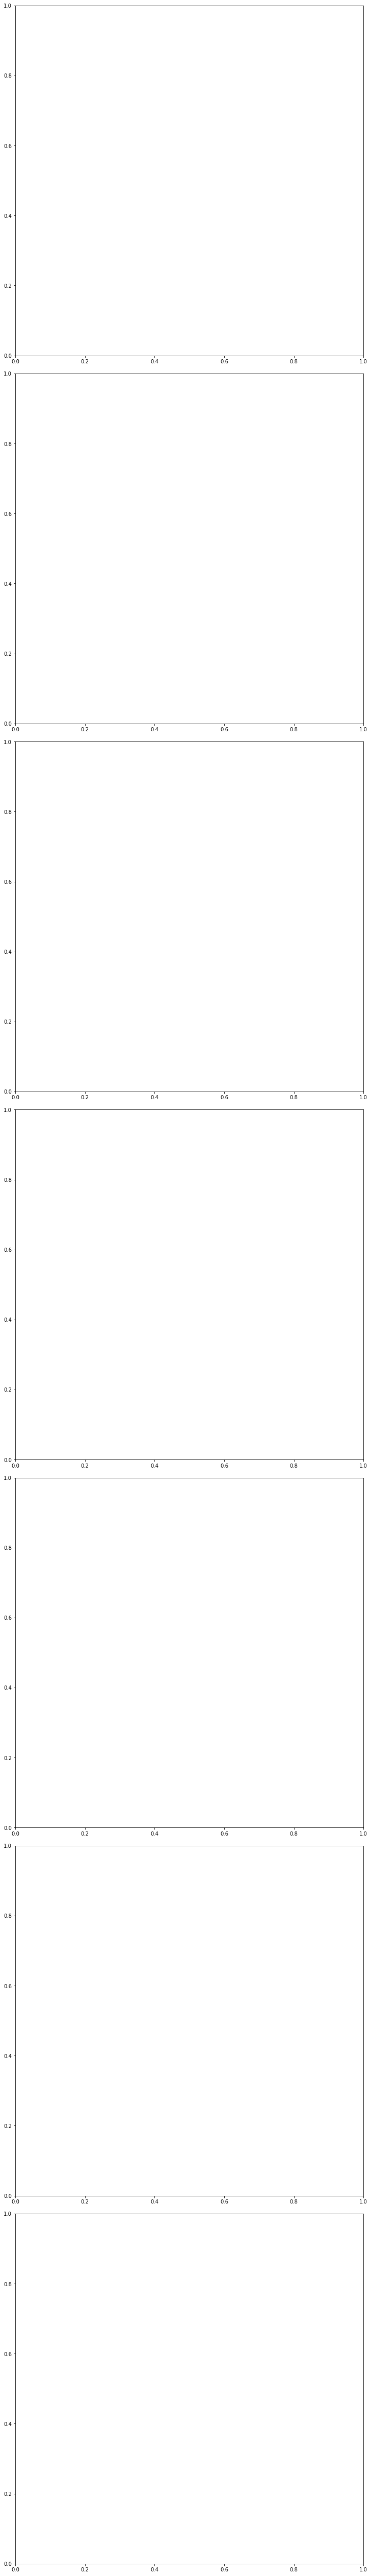

In [23]:
# plots
nregs = len(reglist)
fig = plt.figure(constrained_layout=True,figsize=(10,10*nregs))
axs = fig.subplots(nregs,sharex=False,sharey=False)
for ireg, reg in enumerate(reglist):
    fitreg = fit_dict[reg]
    axi = axs[ireg]
    rplots.plot_leverage_resid2(fitreg,ax=axi)
    axi.set_title("Leverage vs. Normalized residuals squared\n"+reg)